In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jaxdecomp import ShardedArray
import matplotlib.pyplot as plt
import numpy as np
from jaxpm.distributed import normal_field
from lensing_model import make_full_field_model
from diffrax import RecursiveCheckpointAdjoint
from functools import partial

os.environ["EQX_ON_ERROR"] = "nan"
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os

os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [31]:
box_shape = (16, 16, 32)
box_size = [200.0, 200.0, 400.0]
field_size = 3.0  # transverse size in degrees
field_npix = 8  # number of pixels per side
density_plane_width = 50
density_plane_npix = 100
density_plane_smoothing = 0.1

forward_model = make_full_field_model(
    field_size=field_size,
    field_npix=field_npix,
    box_shape=box_shape,
    box_size=box_size,
    density_plane_width=density_plane_width,
    density_plane_npix=density_plane_npix,
    density_plane_smoothing=density_plane_smoothing,
    adjoint=RecursiveCheckpointAdjoint(checkpoints=2)
)

In [35]:
from scipy.stats import norm
import jax_cosmo as jc

z = jnp.linspace(0, 2.5, 1000)

nz_shear = [
    jc.redshift.kde_nz(
        z, norm.pdf(z, loc=z_center, scale=0.12), bw=0.01, zmax=2.5, gals_per_arcmin2=g
    )
    for z_center, g in zip([0.5, 1.0, 1.5, 2.0], [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)
# Define the fiducial cosmology
Planck18 = partial(jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,)

cosmo = Planck18()

# Specify the size and resolution of the patch to simulate
sigma_e = 0.3
print("Pixel size in arcmin: ", field_size * 60 / field_npix)

Pixel size in arcmin:  22.5


Text(0.5, 1.0, 'Redshift distribution')

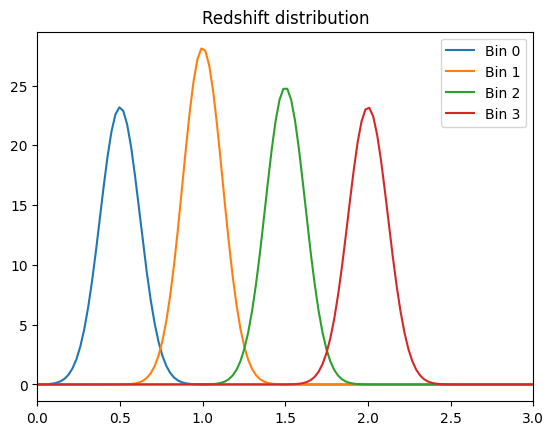

In [33]:
# Plotting the redshift distribution
z = np.linspace(0, 3.0, 128)

for i in range(nbins):
    plt.plot(
        z,
        nz_shear[i](z) * nz_shear[i].gals_per_arcmin2,
        color="C%d" % i,
        label="Bin %d" % i,
    )
plt.legend()
plt.xlim(0, 3)
plt.title("Redshift distribution")

In [36]:
initial_conditions = normal_field(box_shape, seed=jax.random.key(0))
initial_conditions = ShardedArray(initial_conditions)
kappas, lc = forward_model(cosmo, nz_shear, initial_conditions)

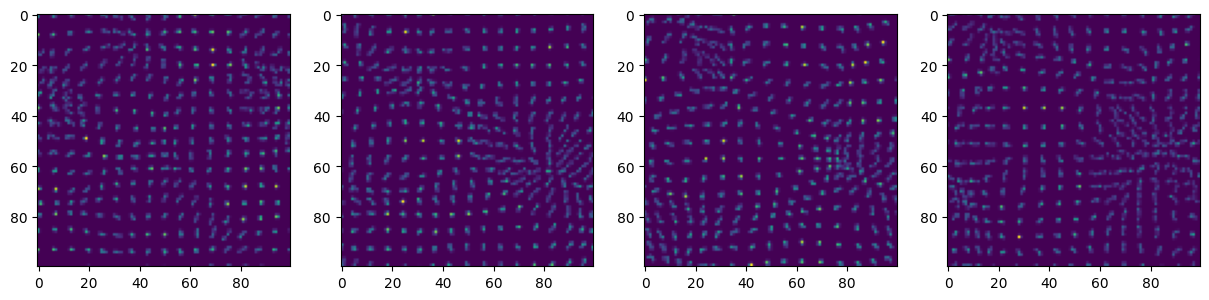

In [37]:
plt.figure(figsize=(15, 5))
for i in range(nbins):
    plt.subplot(1, nbins, i + 1)
    plt.imshow(lc[..., i].data)

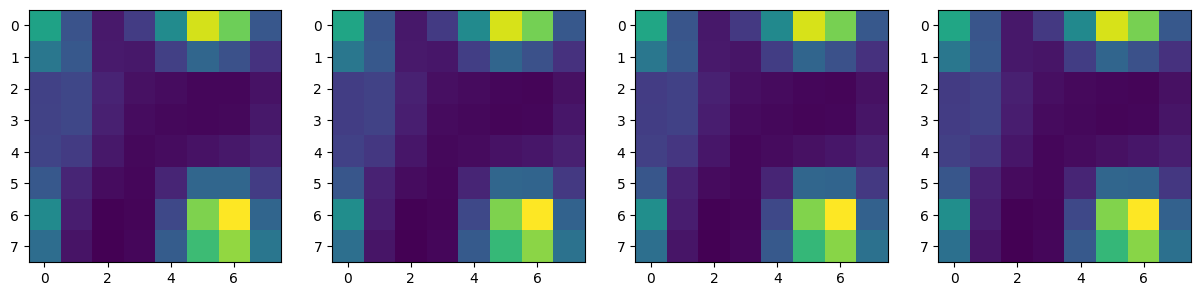

In [38]:
plt.figure(figsize=(15, 5))
for i in range(nbins):
    plt.subplot(1, nbins, i + 1)
    plt.imshow(kappas[i])

In [16]:
def model(cosmo , initial_conditions):
    kappas, _ = forward_model(cosmo, nz_shear, initial_conditions)
    return jnp.mean(jax.tree.reduce(sum , kappas))

In [ ]:
model(cosmo, initial_conditions)

In [18]:
jax.config.update("jax_traceback_filtering", "off")
gr_rev = jax.grad(model,argnums=0 , allow_int=True)(cosmo, initial_conditions)

In [63]:
jax.config.update("jax_traceback_filtering", "off")


In [54]:
from typing import NamedTuple

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace, condition
from numpyro.infer import MCMC, NUTS

class Configurations(NamedTuple):
    field_size: float
    field_npix: int
    box_shape: tuple
    box_size: list
    density_plane_width: int
    density_plane_npix: int
    density_plane_smoothing: float
    nz_shear: list
    fiducial_cosmology: jc.Cosmology
    sigma_e: float
    priors: dict

def full_field_base_model(config):
  forward_model = make_full_field_model(config.field_size, 
                                        config.field_npix,
                                        config.box_shape, 
                                        config.box_size,
                                        config.density_plane_width,
                                        config.density_plane_npix,
                                        config.density_plane_smoothing,
                                        adjoint=RecursiveCheckpointAdjoint(checkpoints=2))
  
  # Sampling the cosmological parameters
  cosmo = config.fiducial_cosmology(**{k: numpyro.sample(k, v) for k, v in config.priors.items()})

  # Sampling the initial conditions
  initial_conditions = numpyro.sample('initial_conditions', dist.Normal(jnp.zeros(config.box_shape),
                                                                        jnp.ones(config.box_shape)))

  initial_conditions = ShardedArray(initial_conditions)

  # Apply the forward model
  convergence_maps, _ = forward_model(cosmo, config.nz_shear, initial_conditions)

  # Define the likelihood of observations
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, 
                                              config.sigma_e/jnp.sqrt(config.nz_shear[i].gals_per_arcmin2*
                                                                      (config.field_size*60/config.field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps


In [55]:
# condition the model on a given set of parameters
fiducial_cosmology = Planck18()

config = Configurations(
        field_size=field_size,
        field_npix=field_npix,
        box_shape=box_shape,
        box_size=box_size,
        density_plane_width=density_plane_width,
        density_plane_npix=density_plane_npix,
        density_plane_smoothing=density_plane_smoothing,
        nz_shear=nz_shear,
        fiducial_cosmology=Planck18,
        sigma_e=sigma_e,
        priors={"Omega_c": dist.Uniform(0.2, 0.4), "sigma8": dist.Uniform(0.6, 1.0), "h": dist.Uniform(0.5, 0.9)}
    )

full_field_probmodel = partial(full_field_base_model , config=config)

fiducial_model = condition(full_field_probmodel, {'Omega_c': fiducial_cosmology.Omega_c,
                                  'sigma8': fiducial_cosmology.sigma8})

    

# sample a mass map and save corresponding true parameters
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

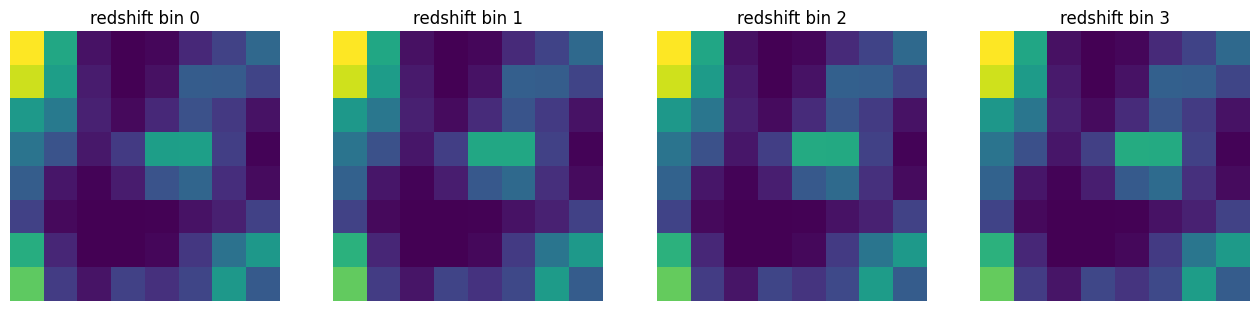

In [56]:
# plotting the trace
plt.figure(figsize=[16,4])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title('redshift bin %d'%i)
    plt.imshow(model_trace['kappa_%d'%i]['fn'].mean)
    plt.axis('off')

In [57]:
# Let's condition the model on the observed maps
observed_model = condition(full_field_base_model, {'kappa_0': model_trace['kappa_0']['value'],
                                   'kappa_1': model_trace['kappa_1']['value'],
                                   'kappa_2': model_trace['kappa_2']['value'],
                                   'kappa_3': model_trace['kappa_3']['value']
                                   })

In [64]:
nuts_kernel = NUTS(
    model=observed_model,
    init_strategy=partial(numpyro.infer.init_to_value, values={'omega_c': cosmo.Omega_c,
                                                               'sigma8': cosmo.sigma8,
                                                               'initial_conditions': model_trace['initial_conditions']['value']}),
    max_tree_depth=3,
    step_size=0.05)

In [67]:
mcmc = MCMC(
       nuts_kernel,
       num_warmup=2,
       num_samples=3,
       #num_chains=5,
       #chain_method='vectorized',
       thinning=1,
       progress_bar=True
    )

mcmc.run(jax.random.PRNGKey(0), config)

sample: 100%|██████████| 5/5 [06:38<00:00, 79.71s/it, 7 steps of size 2.50e-01. acc. prob=0.00] 


In [71]:
cosmo.Omega_c

0.2607

In [74]:
mcmc.get_samples()['initial_conditions'].shape

(3, 16, 16, 32)

In [61]:
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import condition, trace, seed

def model():
    # Step 1: Sample a parameter
    theta = numpyro.sample("theta", dist.Normal(0,1))
    
    # Step 2: Transform it (e.g., square it)
    transformed_theta_1 = theta ** 2
    transformed_theta_2 = 2 * theta
    transformed_theta_3 = jnp.sin(theta)
    transformed_theta_4 = jnp.cos(theta)

    
    # Step 3: Use it as the mean for another sampled variable
    y0 = numpyro.sample("y0", dist.Normal(transformed_theta_1, 0.3))
    y1 = numpyro.sample("y1", dist.Normal(transformed_theta_2, 0.3)) 
    y2 = numpyro.sample("y2", dist.Normal(transformed_theta_3, 0.3))
    y3 = numpyro.sample("y3", dist.Normal(transformed_theta_4, 0.3))
    
    return [y0, y1, y2, y3]

# Predict model by conditioning on theta
def predict_model(rng_key, theta_value):
    conditioned_model = condition(model, data={"theta": theta_value})
    seeded_model = seed(conditioned_model, rng_key)
    traced_model = trace(seeded_model).get_trace()
    y0 = traced_model["y0"]["value"]
    y1 = traced_model["y1"]["value"]
    y2 = traced_model["y2"]["value"]
    y3 = traced_model["y3"]["value"]
    return {"y0": y0, "y1": y1, "y2": y2, "y3": y3}

# Infer theta given observed y
def infer_theta(rng_key, observed_y):
    conditioned_model = condition(model, data=observed_y)
    kernel = NUTS(conditioned_model)
    mcmc = MCMC(kernel, num_warmup=100, num_samples=100)
    mcmc.run(rng_key)
    return mcmc

rng_key = random.PRNGKey(0)
theta_value = 0.7  # Set a fixed theta value for prediction

# Predict y by conditioning on theta
observed_y = predict_model(rng_key, theta_value)
print(f"Observed y: {observed_y}")
# Infer theta from observed y
inferred_theta_samples = infer_theta(rng_key, observed_y)
inferred_theta_samples.print_summary()

Observed y: {'y0': Array(0.54792322, dtype=float64), 'y1': Array(1.40261216, dtype=float64), 'y2': Array(0.37690171, dtype=float64), 'y3': Array(1.12758031, dtype=float64)}


sample: 100%|██████████| 200/200 [00:05<00:00, 38.74it/s, 3 steps of size 8.20e-01. acc. prob=0.94] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.67      0.11      0.68      0.48      0.81     25.24      1.05

Number of divergences: 0
